# main.ipynb with transfer learning implemented


# Setting up Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/MyDrive/{}/src'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

!pip install -q plantcv
!pip install -e .

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/My%20Drive/Lab/Grain-U-Net
  Attempting uninstall: src
    Found existing installation: src 0.0.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -tensorflow


# Train With Sequence

In [ ]:
from pathlib import Path
import numpy as np

train_dir = Path('data/train_nouveaux_256')

input_names = list(train_dir.glob('*/image/*.png'))
label_names = list(train_dir.glob('*/label/*.png'))

print(f"Found {len(input_names)} samples and {len(label_names)} tracings")

Found 299 samples and 299 tracings


In [ ]:
from src import GrainSequence
import random

validation_samples = len(input_names) // 10
batch_size = 5

random.Random(1337).shuffle(input_names)
random.Random(1337).shuffle(label_names)

train_input = input_names[:-validation_samples]
train_label = label_names[:-validation_samples]
train_gen = GrainSequence(batch_size, (256,256), train_input, train_label)

valid_input = input_names[-validation_samples:]
valid_label = label_names[-validation_samples:]
valid_gen = GrainSequence(batch_size, (256,256), valid_input, valid_label)

print(f"Training set size: {len(train_input)}, {len(train_gen)} batches")
print(f"Validation set size: {len(valid_input)}, {len(valid_gen)} batches")

if False:
    _ = [print(f'{ind}:\n{i}\n{l}\n\n') for ind, (i, l) in enumerate(zip(train_input, train_label))]

SyntaxError: ignored

In [ ]:
from src import get_unet
from tensorflow import keras

model = get_unet(input_size = (256, 256, 1))       ###change to dice
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain_nouveaux_posttune.hdf5', monitor='loss', verbose=1, save_best_only=False)
history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_gen), 
    epochs=30, 
    callbacks=[model_checkpoint], 
     validation_data=valid_gen
)

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(10,5), facecolor='White')

plt.title("Loss With Pre Augmentation and Full Dataset (b5, s59)")
plt.xlabel("Epochs")
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

# Transfer onto pt data

**Importing Pt data as sequence**

In [ ]:
from pathlib import Path
import numpy as np

train_dir = Path('data/train_Pt_16')

input_names = list(train_dir.glob('*/image/*.png'))
label_names = list(train_dir.glob('*/label/*.png'))

print(f"Found {len(input_names)} samples and {len(label_names)} tracings")

Found 80 samples and 80 tracings


In [ ]:
from src import GrainSequence
import random

validation_samples = len(input_names) // 10
batch_size = 5

random.Random(1337).shuffle(input_names)
random.Random(1337).shuffle(label_names)

train_input = input_names[:-validation_samples]
train_label = label_names[:-validation_samples]
train_gen = GrainSequence(batch_size, (256,256), train_input, train_label)

valid_input = input_names[-validation_samples:]
valid_label = label_names[-validation_samples:]
valid_gen = GrainSequence(batch_size, (256,256), valid_input, valid_label)

print(f"Training set size: {len(train_input)}, {len(train_gen)} batches")
print(f"Validation set size: {len(valid_input)}, {len(valid_gen)} batches")

if False:
    _ = [print(f'{ind}:\n{i}\n{l}\n\n') for ind, (i, l) in enumerate(zip(train_input, train_label))]

Training set size: 72, 14 batches
Validation set size: 8, 1 batches


**Loading trained Al model and replacing the top layer**

In [ ]:
from src import get_unet
from tensorflow import keras
import numpy as np

model1 = get_unet(input_size=(256,256,1))

load_model = model1
load_model.load_weights('unet_grain_nouveaux_pretune.hdf5')
base_model = load_model.layers[-1].output

In [ ]:
from keras.models import *
from keras.layers import *

model = Model(inputs=model1.input, outputs=base_model)
opt = keras.optimizers.Adam(learning_rate = 5e-6)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics = ['accuracy'])


In [ ]:
for layer in model.layers[13:16]:
    layer.trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

**Fine Tuning the model**

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain_nouveaux_transfer.hdf5', monitor='loss', verbose=1, save_best_only=False)
history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_gen), 
    epochs=10,
    callbacks=[model_checkpoint], 
    validation_data=valid_gen
)

Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9442
Epoch 1: saving model to unet_grain_nouveaux_transfer.hdf5
14/14 [==============================] - 98s 6s/step - loss: 0.1832 - accuracy: 0.9442 - val_loss: 0.1861 - val_accuracy: 0.9425
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9442
Epoch 2: saving model to unet_grain_nouveaux_transfer.hdf5
14/14 [==============================] - 6s 458ms/step - loss: 0.1741 - accuracy: 0.9442 - val_loss: 0.1753 - val_accuracy: 0.9425
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9442
Epoch 3: saving model to unet_grain_nouveaux_transfer.hdf5
14/14 [==============================] - 6s 463ms/step - loss: 0.1715 - accuracy: 0.9442 - val_loss: 0.1775 - val_accuracy: 0.9425
Epoch 4/10
14/14 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9442
Epoch 4: saving model to unet_grain_nouveaux_transfer.hd

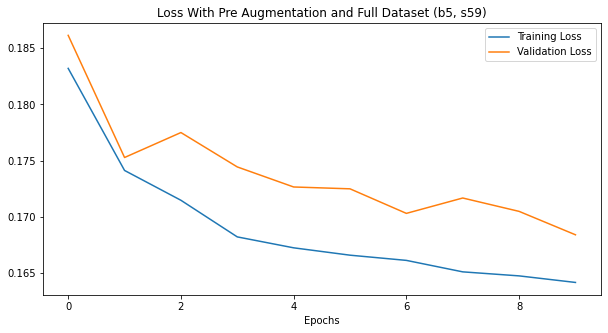

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(10,5), facecolor='White')

plt.title("Loss With Pre Augmentation and Full Dataset (b5, s59)")
plt.xlabel("Epochs")
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()